# Non-parametric models

Here we describe the `PySM` interface to models that can not be described parametrically. `PySM` allows for a set of emission templates at different frequencies to be provided, and then interpolates between these templates in each pixel. 

## Interface

In order to implement your model in `PySM` in this way:

1. Provide a data directory containing a set of $N$ fits files at frequencies $\nu_i$ where $i = 1, 2, ..., N$, each containing the model $[T, Q, U][\nu_i]$ maps. 
2. In this directory provide a file in with two columns:
    - Column 1: each row is frequency $\nu_i$ in GHz. 
    - Column 2: each row is the path to the file containing the $(T, Q, U)[\nu_i]$. 
3. In [`pysm.nominal`](pysm/nominal.py) add a model dictionary with `interpolation=True` and `interp_file='path/to/info/file'`, e.g.: 
```python
    def dust_interpolation(nside, pixel_indices=None):
        return {
            'interpolation': True,
            'interp_file': '/absolute/path/to/file/with/info',
        }
```
4. You can now call this model in the same way as other components: 
```python
    import pysm
    from pysm.nominal import models
    
    def main():
        # Specify the model just created. 
        sky_config = {'dust': models('dust_interpolation', nside)}
        sky = pysm.Sky(sky_config)
        return
```

## Implementation

`PySM` reads in the $3N$ maps, and does a cubic spline interpolation between freuqencies, in each pixel. The interpolation uses the [`scipy.interpolate.CubicSpline`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.CubicSpline.html) routine, with `extrapolation=True`. This means that if the spline is queried at $\nu>\nu_N$ or $\nu<\nu_0$, it will not fail, but will extrapolate the data provided. It is the user's responsibility to ensure that the model provided is densely sampled enough in frequency, and covers a broad enough range of frequencies, that this implementation does not produce undesired results. 

## Example

We now provide an example of implementing a model in this way, from scratch. 

In order to generate the $N$ samples let's just use a simple model:


In [18]:
import numpy as np
import healpy as hp
import os

def power_law(nu, nu_0, beta):
    return (nu / nu_0) ** beta 

n_maps = 10 # number of samples to generate
nu_0 = 353. # reference frequency in model
nu_min = 100 # minimum frequency to include
nu_max = 400 # maximum frequency to include
nside = 64 # nside at which to generate samples
npix = hp.nside2npix(nside)
# Make array of frequencies
nus = np.linspace(nu_min, nu_max, n_maps)
# Make spectral index maps
index = 1.5 + 0.05 * np.random.randn(3 * npix).reshape((3, npix))
# Make sample maps
maps = power_law(nus.reshape(len(nus), 1, 1), nu_0, index)
# Make paths in which to store these sample maps
data_dir = os.path.abspath(os.path.dirname('.'))
fpaths = [os.path.join(data_dir, 'map{:03d}.fits'.format(i)) for i in range(len(maps))]
# Save the sample maps
for fpath, hpix_map in zip(fpaths, maps):
    hp.write_map(fpath, hpix_map, overwrite=True)
# Make an example info file that will be given to PySM with paths to the data. 
dat = np.array(zip(nus, fpaths), dtype=[('nus', float), ('paths', object)])
np.savetxt('test.txt', dat, delimiter=" ", fmt="%.4f %s")

The contents of the info file are:

In [19]:
!cat 'test.txt'

100.0000 /home/bthorne/Projects/PySM/PySM_public/map000.fits
133.3333 /home/bthorne/Projects/PySM/PySM_public/map001.fits
166.6667 /home/bthorne/Projects/PySM/PySM_public/map002.fits
200.0000 /home/bthorne/Projects/PySM/PySM_public/map003.fits
233.3333 /home/bthorne/Projects/PySM/PySM_public/map004.fits
266.6667 /home/bthorne/Projects/PySM/PySM_public/map005.fits
300.0000 /home/bthorne/Projects/PySM/PySM_public/map006.fits
333.3333 /home/bthorne/Projects/PySM/PySM_public/map007.fits
366.6667 /home/bthorne/Projects/PySM/PySM_public/map008.fits
400.0000 /home/bthorne/Projects/PySM/PySM_public/map009.fits


Let's then make the new model dictionary that this would correspond to. In practice we would need to be more careful about paths, because this dictionary would probably live in `pysm.nominal`. But here we are just defining the dictionary in this notebook.

In [20]:
interp_model = [{
    'interpolation': True,
    'interp_file': 'test.txt',
    'nside': 64,
    'pixel_indices': None,
}]

In [21]:
import pysm
sky_config = {'synchrotron': interp_model}
sky = pysm.Sky(sky_config)
signal = sky.signal()

Now check the implementation by comparing the input model and the interpolated version. 

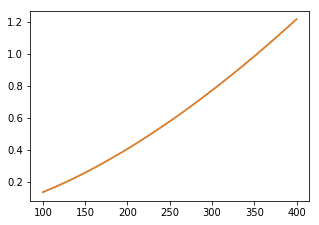

In [22]:
nus_test = np.linspace(nu_min, nu_max, n_maps * 2)


import matplotlib.pyplot as plt
%matplotlib inline 
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
ax.plot(nus_test, signal(nus_test)[:, 0, 1])
ax.plot(nus_test, power_law(nus_test.reshape(len(nus_test), 1, 1), nu_0, index)[:, 0, 1])

So we see excellent agreement for such a simple model, even with only very few samples. Now clean up and remove the generated sample maps:

In [23]:
# Remove maps
for fpath, hpix_map in zip(fpaths, maps):
    os.remove(fpath)
# Remove info file
os.remove('test.txt')